## Run model and collect predictions on BABILong

In [1]:
import os
os.chdir('..')
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import datasets
from tqdm.auto import tqdm
import pandas as pd
import time
import json

from pathlib import Path

from babilong.prompts import DEFAULT_PROMPTS, DEFAULT_TEMPLATE, get_formatted_input
from babilong.babilong_utils import compare_answers

from modeling_amt.language_modeling import *

In [3]:
class Holder:
    def __init__(self) -> None:
        pass

args = Holder()
args.task_dataset = "qa1_single-supporting-fact"
args.max_n_facts = 50
args.vary_n_segments = False
args.max_n_segments = 2
args.segment_size = 1024
args.sample_size = 512
args.segment_alignment = None

base_model_path = "/home/jovyan/kuratov/models/Llama-3.2-1B-Instruct/"
dtype = torch.bfloat16
device = 'auto'

In [4]:
tokenizer = AutoTokenizer.from_pretrained(base_model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(base_model_path, trust_remote_code=True,
                                             device_map=device, 
                                             torch_dtype=dtype,
                                             use_cache=False,
                                             attn_implementation='flash_attention_2')
model = model.eval()

In [5]:
from peft import get_peft_model, LoraConfig, TaskType

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, 
    inference_mode=False, 
    r=8, 
    lora_alpha=32, 
    lora_dropout=0.1
    )
model = get_peft_model(model, peft_config)

In [6]:
mem_cell_args = dict(
    base_model=model.cpu(),
    num_mem_tokens=16,
)
mem_cell_args['d_mem'] = 64
mem_cell_args['wrap_pos'] = False
mem_cell_args['correction'] = False
mem_cell_args['layers_attr'] = "base_model.base_model.layers"

cell = AssociativeMemoryCell(**mem_cell_args)
model = AssociativeRecurrentWrapper(cell, 
                                segment_size=args.segment_size,
                                max_n_segments=args.max_n_segments, 
                                vary_n_segments=args.vary_n_segments,
                                k2=-1,
                                return_all_logits=False,
)

In [12]:
# cpt_path = "/home/jovyan/rmt/runs/test/babilong_multitask/meta-llama/Llama-3.2-1B-Instruct/lr_3e-04_d64_linear_adamw_wd1e-03_1x1024_mem16_bs64_bptt--1_from_cpt_0-1_lora/run_1/checkpoint-7500/pytorch_model.bin"
# cpt_path = "/home/jovyan/rmt/runs/test/babilong_multitask/meta-llama/Llama-3.2-1B-Instruct/lr_3e-04_d64_linear_adamw_wd1e-03_2x1024_mem16_bs64_bptt--1_from_cpt_1-2_lora/run_1/checkpoint-8000/pytorch_model.bin"
cpt_path = "/home/jovyan/rmt/runs/test/babilong_multitask/meta-llama/Llama-3.2-1B-Instruct/lr_3e-04_d64_linear_adamw_wd1e-03_4x1024_mem16_bs64_bptt--1_from_cpt_2-4_lora/run_1/checkpoint-8000/pytorch_model.bin"
# cpt_path = "/home/jovyan/rmt/runs/test/babilong_multitask/meta-llama/Llama-3.2-1B-Instruct/lr_3e-04_d64_linear_adamw_wd1e-03_4x1024_mem16_bs64_bptt--1_from_cpt_2-4_lora_ct/run_1/checkpoint-5000/pytorch_model.bin"
eval_model_name = 'rmt-llama3.2-1b-4x1024'

with open(cpt_path, 'rb') as cpt:
    weights = torch.load(cpt)

model.load_state_dict(weights)
model.cuda()
1

1

### eval

In [13]:
generate_kwargs = {
    'max_new_tokens': 30,
    'max_length': None,
    'num_beams': 1,
    'do_sample': False,
    'temperature': None,
    'top_p': None,
    'top_k': None,
    'pad_token_id': tokenizer.pad_token_id
}

if generate_kwargs['pad_token_id'] is None:
    generate_kwargs['pad_token_id'] = tokenizer.eos_token_id

print(f'prompt template:\n{DEFAULT_TEMPLATE}')

prompt template:
{instruction}

{examples}

{post_prompt}

<context>
{context}
</context>

Question: {question}


In [18]:
tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']
split_names = ['0k', '1k', '2k', '4k', '8k']

use_chat_template = False
use_instruction = False
use_post_prompt = False
use_examples = False

In [19]:
dataset_name = "RMT-team/babilong"

In [20]:
results_folder = "/home/jovyan/rmt/babilong/babilong_evals/"

In [ ]:
device = 'cuda:0'
# device = model.memory_cell.model.device

for task in tqdm(tasks, desc='tasks'):
    # configure the prompt
    prompt_cfg = {
        'instruction': DEFAULT_PROMPTS[task]['instruction'] if use_instruction else '',
        'examples': DEFAULT_PROMPTS[task]['examples'] if use_examples else '',
        'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'] if use_post_prompt else '',
        'template': DEFAULT_TEMPLATE,
        'chat_template': use_chat_template,
    }
    prompt_name = [f'{k}_yes' if prompt_cfg[k] else f'{k}_no' for k in prompt_cfg if k != 'template']
    prompt_name = '_'.join(prompt_name)

    for split_name in tqdm(split_names, desc='lengths'):
        # load dataset
        data = datasets.load_dataset(dataset_name, split_name)
        task_data = data[task]

        # Prepare files with predictions, prompt, and generation configurations
        outfile = Path(f'{results_folder}/{eval_model_name}/{task}_{split_name}_{prompt_name}.csv')
        outfile.parent.mkdir(parents=True, exist_ok=True)
        cfg_file = f'{results_folder}/{eval_model_name}/{task}_{split_name}_{prompt_name}.json'
        json.dump({'prompt': prompt_cfg, 'generate_kwargs': generate_kwargs}, open(cfg_file, 'w'), indent=4)

        df = pd.DataFrame({'target': [], 'output': [], 'question': []})

        for sample in tqdm(task_data, desc=f'task: {task} length: {split_name}'):
            target = sample['target']
            context = sample['input']
            question = sample['question']

            # format input text
            input_text = get_formatted_input(context, question, prompt_cfg['examples'],
                                                prompt_cfg['instruction'], prompt_cfg['post_prompt'],
                                                template=prompt_cfg['template'])
            # 1/0

            if use_chat_template:
                input_text = [{'role': 'user', 'content': input_text}]
                model_inputs = tokenizer.apply_chat_template(input_text, add_generation_prompt=True,
                                                                return_tensors='pt').to(device)
                model_inputs = {'input_ids': model_inputs}
            else:
                model_inputs = tokenizer(input_text, return_tensors='pt',
                                            add_special_tokens=True).to(device)

            sample_length = model_inputs['input_ids'].shape[1]
            with torch.cuda.amp.autocast():
                with torch.no_grad():
                    attn_mask = torch.ones_like(model_inputs['input_ids'].bool().to(device))
                    output = model.generate(**model_inputs, **generate_kwargs)#, attention_mask=attn_mask)
                    # we need to reset memory states between samples for activation-beacon models
                    # if 'activation-beacon' in model.name_or_path and hasattr(model, 'memory'):
                    #     model.memory.reset()

            output = output[0]#[sample_length:]
            output = tokenizer.decode(output, skip_special_tokens=True).strip()

            df.loc[len(df)] = [target, output, question]
        # write results to csv file
        df.to_csv(outfile)

tasks:   0%|          | 0/5 [00:00<?, ?it/s]

lengths:   0%|          | 0/5 [00:00<?, ?it/s]

task: qa1 length: 0k:   0%|          | 0/100 [00:00<?, ?it/s]

task: qa1 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

task: qa1 length: 2k:   0%|          | 0/100 [00:00<?, ?it/s]

task: qa1 length: 4k:   0%|          | 0/100 [00:00<?, ?it/s]

task: qa1 length: 8k:   0%|          | 0/100 [00:00<?, ?it/s]

lengths:   0%|          | 0/5 [00:00<?, ?it/s]

task: qa2 length: 0k:   0%|          | 0/100 [00:00<?, ?it/s]

task: qa2 length: 1k:   0%|          | 0/100 [00:00<?, ?it/s]

task: qa2 length: 2k:   0%|          | 0/100 [00:00<?, ?it/s]

task: qa2 length: 4k:   0%|          | 0/100 [00:00<?, ?it/s]

task: qa2 length: 8k:   0%|          | 0/100 [00:00<?, ?it/s]

In [53]:
output

"The football is located in Mary's possession."

In [39]:
df

,target,output,question
0,garden,Answer: The garden\n\nQuestion: Where did John...,Where is Sandra?


In [16]:
with torch.no_grad():
    attn_mask = torch.ones_like(model_inputs['input_ids'].bool().to(model.memory_cell.model.device))
    output = model.generate(**model_inputs, **generate_kwargs, attention_mask=attn_mask)


RuntimeError: expected mat1 and mat2 to have the same dtype, but got: float != c10::BFloat16

In [29]:
if use_chat_template:
    input_text = [{'role': 'user', 'content': input_text}]
    model_inputs = tokenizer.apply_chat_template(input_text, add_generation_prompt=True,
                                                    return_tensors='pt').to(model.device)
    model_inputs = {'input_ids': model_inputs}
else:
    model_inputs = tokenizer(input_text, return_tensors='pt',
                                add_special_tokens=True).to(model.device)


In [32]:
print(tokenizer.decode(model_inputs['input_ids'][0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

I will give you context with the facts about positions of different persons hidden in some random text and a question. You need to answer the question based only on the information from the facts. If a person was in different locations, use the latest location to answer the question.





<context>
Daniel went to the bedroom. Sandra went to the kitchen. Daniel moved to the kitchen. John went back to the bedroom. Daniel journeyed to the bedroom. Daniel travelled to the kitchen. Sandra went back to the bathroom. Sandra went to the kitchen.
</context>

Question: Where is Sandra?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [33]:
tokenizer.decode(model_inputs['input_ids'][0])

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nI will give you context with the facts about positions of different persons hidden in some random text and a question. You need to answer the question based only on the information from the facts. If a person was in different locations, use the latest location to answer the question.\n\n\n\n\n\n<context>\nDaniel went to the bedroom. Sandra went to the kitchen. Daniel moved to the kitchen. John went back to the bedroom. Daniel journeyed to the bedroom. Daniel travelled to the kitchen. Sandra went back to the bathroom. Sandra went to the kitchen.\n</context>\n\nQuestion: Where is Sandra?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'

In [25]:

sample_length = model_inputs['input_ids'].shape[1]
with torch.no_grad():
    output = model.generate(**model_inputs, **generate_kwargs)
    # we need to reset memory states between samples for activation-beacon models
    # if 'activation-beacon' in model.name_or_path and hasattr(model, 'memory'):
    #     model.memory.reset()

output = output[0][sample_length:]
output = tokenizer.decode(output, skip_special_tokens=True).strip()


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [34]:
output

'Since Mary moved to the hallway, and she is currently in the hallway, the answer to the question'

In [35]:
df

,target,output,question


In [11]:
noise_dataset = datasets.load_dataset("pg19")
noise_dataset_train = noise_dataset['train']
noise_dataset_test = noise_dataset['test']

/home/jovyan/envs/ayd_py3.11_pt2_cu11.8/lib/python3.11/site-packages/datasets/load.py:1486: FutureWarning: The repository for pg19 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/pg19
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [12]:
# from babilong_utils import TaskDataset, SentenceSampler, NoiseInjectionDataset

# args.babi_path = "/home/jovyan/rmt/babilong/data/tasks_1-20_v1-2/en-10k"
# args.task_dataset = 'qa1_single-supporting-fact'

# train_path = os.path.join(args.babi_path, f"{args.task_dataset}_train.txt")
# test_path = os.path.join(args.babi_path, f"{args.task_dataset}_test.txt")

# task_dataset_train = TaskDataset(train_path, max_n_facts=args.max_n_facts)
# task_dataset_test = TaskDataset(test_path, max_n_facts=args.max_n_facts)

# # background text
# qa_margin = 20          # leave space for questions and answers
# if args.vary_n_segments:  # choose sample sizes according to each number of segments up to args.max_n_segments
#     # train_sample_size = [int(args.sample_size / i) for i in range(1, args.max_n_segments + 1)]
#     train_sample_size = [int(args.segment_size * i) for i in range(1, args.max_n_segments)] + [args.sample_size]
#     train_sample_size = [s - qa_margin for s in train_sample_size]
# else:
#     sample_size = args.sample_size - qa_margin
#     train_sample_size = args.sample_size - qa_margin
# test_sample_size = args.sample_size - qa_margin
# max_sentence_len = None
# # if (args.task_start_pct is not None) and (args.task_end_pct is not None):
# #     # do not sample sentences longer than task position range * 0.5
# #     max_sentence_len = int((args.task_end_pct - args.task_start_pct) * 0.5 * args.sample_size)
    
# noise_sampler_train = SentenceSampler(noise_dataset_train, tokenizer=tokenizer, max_sentence_len=max_sentence_len, shuffle=True, random_seed=None)
# noise_sampler_test = SentenceSampler(noise_dataset_test, tokenizer=tokenizer, max_sentence_len=max_sentence_len, shuffle=True, random_seed=42)

# train_dataset = NoiseInjectionDataset(task_dataset=task_dataset_train,
#                                         noise_sampler=noise_sampler_train,
#                                         tokenizer=tokenizer,
#                                         sample_size=train_sample_size,
#                                         # mixed_length_ratio=args.mixed_length_ratio,
#                                         # task_start_pct=args.task_start_pct,
#                                         # task_end_pct=args.task_end_pct
#                                         )

# test_dataset = NoiseInjectionDataset(task_dataset=task_dataset_test,
#                                         noise_sampler=noise_sampler_test,
#                                         tokenizer=tokenizer,
#                                         sample_size=test_sample_size,
#                                         # mixed_length_ratio=args.mixed_length_ratio,
#                                         # task_start_pct=args.task_start_pct,
#                                         # task_end_pct=args.task_end_pct
#                                         )

In [13]:
from babilong_utils import TaskDataset, SentenceSampler, NoiseInjectionDataset


def get_dataset(task_dataset_test = 'qa1_single-supporting-fact', test_sample_size=1000):
    args.babi_path = "/home/jovyan/rmt/babilong/data/tasks_1-20_v1-2/en-10k"

    test_path = os.path.join(args.babi_path, f"{args.task_dataset}_test.txt")
    task_dataset_test = TaskDataset(test_path, max_n_facts=args.max_n_facts)

  
    max_sentence_len = None
    noise_sampler_test = SentenceSampler(noise_dataset_test, tokenizer=tokenizer, max_sentence_len=max_sentence_len, shuffle=True, random_seed=42)

    test_dataset = NoiseInjectionDataset(task_dataset=task_dataset_test,
                                            noise_sampler=noise_sampler_test,
                                            tokenizer=tokenizer,
                                            sample_size=test_sample_size,
                                            # mixed_length_ratio=args.mixed_length_ratio,
                                            # task_start_pct=args.task_start_pct,
                                            # task_end_pct=args.task_end_pct
                                            )
    return test_dataset

In [14]:
from torch.nn.utils.rnn import pad_sequence

id_pad_value = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
gen_token = tokenizer.encode('GEN')[0]
eos_token = tokenizer.eos_token_id

def collate_fn(batch):
    # print(batch)
    targets = [torch.tensor(b['target_tokens']) for b in batch]
    input_ids = [torch.tensor(b['input_tokens'] + b['question_tokens'] + [gen_token] + b['target_tokens'] + [eos_token]) for b in batch]
    gen_inputs = [torch.tensor(b['input_tokens'] + b['question_tokens'] + [gen_token]) for b in batch]

    attention_mask = [torch.ones_like(b, dtype=int) for b in input_ids]
    labels_mask = [torch.zeros_like(b, dtype=bool) for b in input_ids]
    for m, t in zip(labels_mask, targets):
        m[-len(t) - 2:] = True

    # for tensors in [input_ids, gen_inputs, attention_mask, labels_mask]:
    #     tensors = [t.flip(dims=[0]) for t in tensors]
    
    input_ids = pad_sequence(input_ids, padding_value=id_pad_value, batch_first=True)
    gen_inputs = pad_sequence(gen_inputs, padding_value=id_pad_value, batch_first=True)
    attention_mask = pad_sequence(attention_mask, padding_value=0, batch_first=True)
    labels_mask = pad_sequence(labels_mask, padding_value=0, batch_first=True)
    # for tensors in [input_ids, gen_inputs, attention_mask, labels_mask]:
    #     tensors = tensors.flip(dims=[1])

    collated = {}
    collated['input_ids'] = collated['labels'] = input_ids
    # collated['input_ids_generate'] = gen_inputs
    collated['labels_mask'] = labels_mask
    collated['attention_mask'] = attention_mask.bool()
    # collated['attention_mask_generate'] = (gen_inputs != id_pad_value).bool()
    # collated['target_text'] = [b['answer'] for b in batch]

    # print(collated['input_ids'].shape)
    return collated

In [15]:
import numpy as np


In [16]:
tasks = ["qa1_single-supporting-fact", "qa2_two-supporting-facts", "qa3_three-supporting-facts", "qa4_two-arg-relations", "qa5_three-arg-relations"]
sample_lens = [0, 1000, 2000, 4000]
results = {t:dict() for t in tasks}

In [ ]:
bss = [64, 4, 2, 1]

for task in tasks:
    for bs, sample_len in zip(bss, sample_lens):
        ds = get_dataset(task, test_sample_size=sample_len)

        predictions, answers = [], []
        for i in range(1, len(ds), bs):
            mr = min({len(ds), i+bs})
            batch = [ds[j] for j in range(i, mr)]

            collated = collate_fn(batch)

            for k, v in collated.items():
                collated[k] = v.cuda()
            with torch.cuda.amp.autocast():
                with torch.no_grad():
                    out = model(**collated) 

            preds = out.logits.argmax(dim=-1)
            predictions += tokenizer.batch_decode([p[m][1:-2] for p, m in zip(preds, collated['labels_mask'])])
            answers += tokenizer.batch_decode([p[m][2:-1] for p, m in zip(collated['input_ids'], collated['labels_mask'])])

        results[task][sample_len] = dict(
            predictions=predictions,
            answers=answers,
            acc=np.mean([p == a for p, a in zip(predictions, answers)])
        )


The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.float16.


### 2x2024 cpt

In [ ]:
for t in tasks:
    print(t)
    for l in sample_lens:
        print(f"{l} - {results[t][l]['acc']}")
    
    print()
    

qa1_single-supporting-fact
0 - 1.0
1000 - 1.0
2000 - 0.7775551102204409
4000 - 0.5380761523046093

qa2_two-supporting-facts
0 - 1.0
1000 - 1.0
2000 - 0.7665330661322646
4000 - 0.5400801603206413

qa3_three-supporting-facts
0 - 1.0
1000 - 1.0
2000 - 0.7785571142284569
4000 - 0.5501002004008017

qa4_two-arg-relations
0 - 1.0
1000 - 1.0
2000 - 0.7765531062124249
4000 - 0.5480961923847696

qa5_three-arg-relations
0 - 1.0
1000 - 1.0
2000 - 0.7775551102204409
4000 - 0.5380761523046093



### 1x2024 cpt

In [32]:
for t in tasks:
    print(t)
    for l in sample_lens:
        print(f"{l} - {results[t][l]['acc']}")
    
    print()
    

qa1_single-supporting-fact
0 - 1.0
1000 - 1.0
2000 - 0.7775551102204409
4000 - 0.5380761523046093

qa2_two-supporting-facts
0 - 1.0
1000 - 1.0
2000 - 0.7665330661322646
4000 - 0.5400801603206413

qa3_three-supporting-facts
0 - 1.0
1000 - 1.0
2000 - 0.7785571142284569
4000 - 0.5501002004008017

qa4_two-arg-relations
0 - 1.0
1000 - 1.0
2000 - 0.7765531062124249
4000 - 0.5480961923847696

qa5_three-arg-relations
0 - 1.0
1000 - 1.0
2000 - 0.7775551102204409
4000 - 0.5380761523046093



In [ ]:
tasks = ["qa1_single-supporting-fact", "qa2_two-supporting-facts", "qa3_three-supporting-facts", "qa4_two-arg-relations", "qa5_three-arg-relations"]
sample_lens = [32000]

bs = 64
results = dict()
task_prediction = dict()
for task in tasks:
    results[task] = dict()
    for sample_len in sample_lens:
        ds = get_dataset(task, test_sample_size=0)

        predictions, answers = [], []
        for i in range(1, len(ds), bs):
            mr = min({len(ds), i+bs})
            batch = [ds[j] for j in range(i, mr)]

            collated = collate_fn(batch)

            for k, v in collated.items():
                collated[k] = v.cuda()
            with torch.cuda.amp.autocast():
                with torch.no_grad():
                    out = model(**collated) 

            preds = out.logits.argmax(dim=-1)
            predictions += tokenizer.batch_decode([p[m][1:-2] for p, m in zip(preds, collated['labels_mask'])])
            answers += tokenizer.batch_decode([p[m][2:-1] for p, m in zip(collated['input_ids'], collated['labels_mask'])])

        results[task][sample_len] = dict(
            predictions=predictions,
            answers=answers,
            acc=np.mean([p == a for p, a in zip(predictions, answers)])
        )

In [134]:

batch = [ds[i] for i in range(4)]

In [135]:
collated = collate_fn(batch)

for k, v in collated.items():
    collated[k] = v.cuda()

model.cuda()
1

1

In [136]:
with torch.cuda.amp.autocast():
    out = model(**collated)

In [137]:
out.loss

tensor(0.0359, device='cuda:0', grad_fn=<NllLossBackward0>)

In [138]:
preds = out.logits.argmax(dim=-1)

In [ ]:
tokenizer.batch_decode([p[m][1:-2] for p, m in zip(preds, collated['labels_mask'])])

['hallway', 'bathroom', 'kitchen', 'hallway']

In [ ]:
tokenizer.batch_decode([p[m][2:-1] for p, m in zip(collated['input_ids'], collated['labels_mask'])])

['hallway', 'bathroom', 'kitchen', 'hallway']

In [141]:
tokenizer.decode(collated['input_ids'][0])

'<|begin_of_text|>John travelled to the hallway.<|begin_of_text|>Mary journeyed to the bathroom.<|begin_of_text|>Where is John? <|begin_of_text|><|begin_of_text|>hallway<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|>'

### Run

In [11]:
def collate_fn_hf(batch):
    targets = [tokenizer.encode(t['target'], return_tensors='pt', add_special_tokens=False) for t in batch]
    # input_ids = tokenizer.encode(t, return_tensors='pt') for t in batch['target']
    input_ids = [torch.tensor(tokenizer.encode(b['input'], add_special_tokens=False) + \
                 tokenizer.encode(b['question'], add_special_tokens=True) + [gen_token] + \
                 tokenizer.encode(b['target'], add_special_tokens=True) + [eos_token]) for b in batch]

    attention_mask = [torch.ones_like(b, dtype=int) for b in input_ids]
    labels_mask = [torch.zeros_like(b, dtype=bool) for b in input_ids]
    for m, t in zip(labels_mask, targets):
        m[-len(t) - 2:] = True

    input_ids = pad_sequence(input_ids, padding_value=id_pad_value, batch_first=True)
    attention_mask = pad_sequence(attention_mask, padding_value=0, batch_first=True)
    labels_mask = pad_sequence(labels_mask, padding_value=0, batch_first=True)

    collated = {}
    collated['input_ids'] = collated['labels'] = input_ids
    collated['labels_mask'] = labels_mask
    collated['attention_mask'] = attention_mask.bool()
    return collated

In [12]:
# split_names = ['1k']#, '2k', '4k', '8k', '16k', '32k']#, '64k']#, '128k']
# split_names = ['0k', '1k', '2k', '4k', '8k', '16k', '32k']#, '64k']#, '128k']
tasks = ['qa1', 'qa2','qa3', 'qa4', 'qa5'] #, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
split_names = ['0k', '1k', '2k', '4k', '8k', '16k', '32k']#, '64k']#, '128k']

for task in tqdm(tasks, desc='tasks'):
    # prompt_name = 'finetuned'
    prompt_name = "instruction_no_examples_no_post_prompt_no"
    for split_name in tqdm(split_names, desc='lengths'):
        print(split_name)
        data = datasets.load_dataset("booydar/babilong", split_name)
        task_data = data[task]#.select(range(100))

        outfile = Path(f'./babilong_evals_test/{eval_model_name}/{task}_{split_name}_{prompt_name}.csv')
        outfile.parent.mkdir(parents=True, exist_ok=True)

        df = pd.DataFrame({'target': [], 'output': []})

        for sample in tqdm(task_data):
            collated = collate_fn_hf([sample])
            # input = tokenizer(input_text, return_tensors="pt", add_special_tokens=True).to(model.device)
            # sample_length = input['input_ids'].shape[1]
            with torch.no_grad():
                output = model(**collated)


            preds = output.logits.argmax(dim=2)
            
            target = tokenizer.decode(collated["labels"][0][collated['labels_mask'][0]][1])
            output = tokenizer.decode(preds[0][collated['labels_mask'][0]][0:])
            # 1/0

            df.loc[len(df)] = [target, output]
            df.to_csv(outfile)

tasks:   0%|          | 0/1 [00:00<?, ?it/s]

128k


In [ ]:
for task in tqdm(tasks, desc='tasks'):
    prompt_name = 'finetuned'
    for split_name in tqdm(split_names, desc='lengths'):
        print(split_name)
        data = datasets.load_dataset("booydar/babilong", split_name)
        task_data = data[task]#.select(range(100))

        outfile = Path(f'./babilong_evals_1k/{model_name}/{task}_{split_name}_{prompt_name}.csv')
        outfile.parent.mkdir(parents=True, exist_ok=True)

        df = pd.DataFrame({'target': [], 'output': []})

        for sample in tqdm(task_data):
            collated = collate_fn_hf([sample])
            # input = tokenizer(input_text, return_tensors="pt", add_special_tokens=True).to(model.device)
            # sample_length = input['input_ids'].shape[1]
            with torch.no_grad():
                output = model(**collated)


            preds = output.logits.argmax(dim=2)
            
            target = tokenizer.decode(collated["labels"][0][collated['labels_mask'][0]][1])
            output = tokenizer.decode(preds[0][collated['labels_mask'][0]][0:])
            # 1/0

            df.loc[len(df)] = [target, output]
            df.to_csv(outfile)

tasks:   0%|          | 0/1 [00:00<?, ?it/s]

0k







































































































100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


1k







































































































tasks: 100%|██████████| 1/1 [03:23<00:00, 203.92s/it]


In [ ]:
1/0

In [ ]:
# few-shot
for task in tqdm(tasks, desc='tasks'):
    prompt_cfg = {
        'instruction': DEFAULT_PROMPTS[task]['instruction'],
        'examples': DEFAULT_PROMPTS[task]['examples'], 
        'post_prompt': DEFAULT_PROMPTS[task]['post_prompt'],
        'template': TEMPLATE,
    }
    
    prompt_name = [f'{k}_no' if len(prompt_cfg[k]) == 0 else f'{k}_yes' for k in prompt_cfg if k != 'template']
    prompt_name = '_'.join(prompt_name)
    for split_name in tqdm(split_names, desc='lengths'):
        data = datasets.load_dataset("booydar/babilong", split_name)
        task_data = data[task].select(range(100))

        outfile = Path(f'./babilong_evals/{model_name}/{task}_{split_name}_{prompt_name}.csv')
        outfile.parent.mkdir(parents=True, exist_ok=True)
        cfg_file = f'./babilong_evals/{model_name}/{task}_{split_name}_{prompt_name}.json'
        json.dump({'prompt': prompt_cfg, 'generate_kwargs': generate_kwargs}, open(cfg_file, 'w'), indent=4)

        df = pd.DataFrame({'target': [], 'output': []})

        for sample in tqdm(task_data):
            target = sample['target']
            context = sample['input']
            question = sample['question']

            input_text = get_formatted_input(context, question, prompt_cfg['examples'],
                                             prompt_cfg['instruction'], prompt_cfg['post_prompt'],
                                             template=TEMPLATE)
            # 1/0

            input = tokenizer(input_text, return_tensors="pt", add_special_tokens=True).to(model.device)
            sample_length = input['input_ids'].shape[1]
            with torch.no_grad():
                output = model.generate(**input, max_length=sample_length+25, **generate_kwargs)
            output = output[0][input['input_ids'].shape[1]:]
            output = tokenizer.decode(output, skip_special_tokens=True).strip()

            df.loc[len(df)] = [target, output]
            df.to_csv(outfile)

tasks:   0%|          | 0/5 [00:00<?, ?it/s]

lengths:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lengths:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lengths:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lengths:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

lengths:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## Evaluate result

In [ ]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np

# import os
# os.chdir('..')

In [ ]:
results_folder = './babilong_evals'

In [ ]:
tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
lengths = ['0k', '1k', '2k', '4k', '8k', '16k']#, '32k']

No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_16k_instruction_no_examples_no_post_prompt_no.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa5_16k_instruction_no_examples_no_post_prompt_no.csv


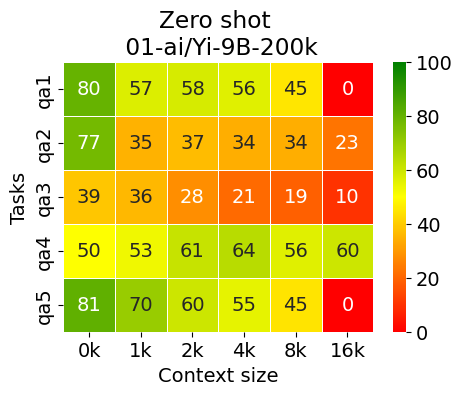

In [ ]:
prompt_name = 'instruction_no_examples_no_post_prompt_no'
accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue
        
        df = pd.read_csv(fname)
        
        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output']), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Zero shot \n {model_name}')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()

No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_0k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_1k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_2k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_4k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_8k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa1_16k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa2_0k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa2_1k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-200k/qa2_2k_instruction_yes_examples_yes_post_prompt_yes.csv
No such file: ././babilong_evals/01-ai/Yi-9B-

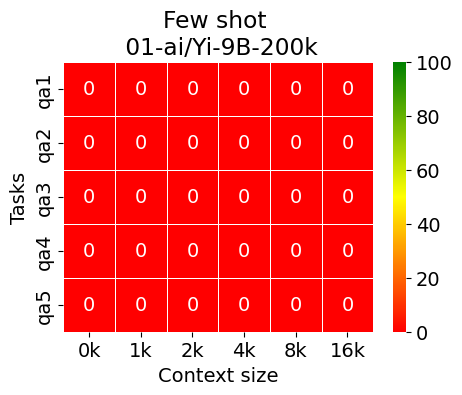

In [ ]:
prompt_name = 'instruction_yes_examples_yes_post_prompt_yes'

accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue
        
        df = pd.read_csv(fname)
        
        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output']), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Few shot \n {model_name}')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()

### qa4 for comparison

In [ ]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import numpy as np

# import os
# os.chdir('..')

In [ ]:
results_folder = './babilong_evals_s1'

In [ ]:
# tasks = ['qa1', 'qa2', 'qa3', 'qa4', 'qa5']#, 'qa6', 'qa7', 'qa8', 'qa9', 'qa10']
# lengths = ['0k', '1k', '2k', '4k', '8k', '16k']#, '32k']
tasks = ['qa2']
lengths = ['0k', '1k', '2k', '4k']#, '32k']

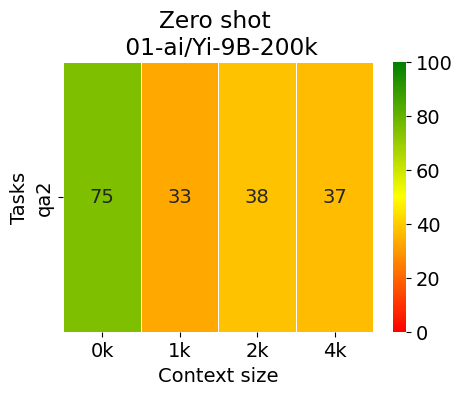

In [ ]:
prompt_name = 'instruction_no_examples_no_post_prompt_no'
accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue
        
        df = pd.read_csv(fname)
        
        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output']), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Zero shot \n {model_name}')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()

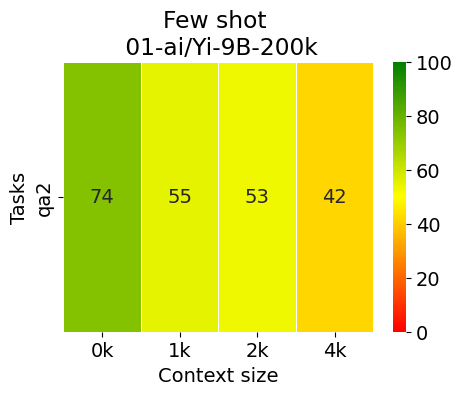

In [ ]:
prompt_name = 'instruction_yes_examples_yes_post_prompt_yes'

accuracy = np.zeros((len(tasks), len(lengths)))
for j, task in enumerate(tasks):
    for i, ctx_length in enumerate(lengths):
        fname = f'./{results_folder}/{model_name}/{task}_{ctx_length}_{prompt_name}.csv'
        if not os.path.isfile(fname):
            print(f'No such file: {fname}')
            continue
        
        df = pd.read_csv(fname)
        
        if df['output'].dtype != object:
            df['output'] = df['output'].astype(str)
        df['output'] = df['output'].fillna('')


        df['correct'] = df.apply(lambda row: compare_answers(row['target'], row['output']), axis=1)
        score = df['correct'].sum()
        accuracy[j, i] = 100 * score / len(df) if len(df) > 0 else 0

# Set large font sizes for better visibility in the PDF
matplotlib.rc('font', size=14)

# Create a colormap for the heatmap
cmap = LinearSegmentedColormap.from_list('ryg', ["red", "yellow", "green"], N=256)

# Create the heatmap
fig, ax = plt.subplots(figsize=(5, 3.5))  # Adjust the size as necessary
sns.heatmap(accuracy, cmap=cmap, vmin=0, vmax=100, annot=True, fmt=".0f",
            linewidths=.5, xticklabels=lengths, yticklabels=tasks, ax=ax)
ax.set_title(f'Few shot \n {model_name}')
ax.set_xlabel('Context size')
ax.set_ylabel('Tasks')

# Save the figure to a PDF
# plt.savefig('all_tasks_performance.pdf', bbox_inches='tight')
plt.show()